# Modules import

In [1]:
import os
from typing import Dict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import spacy
import re
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaminskia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Required commands
```bash
python -m textblob.download_corpora
python -m spacy download en_core_web_sm
``` 

# Data import

In [2]:
DATA_PATH = os.path.join("..", "data", "gpt-2-ouput-dataset")
FAKE_DATA_PATH = "medium-345M-k40"
REAL_DATA_PATH = "webtext"
LABEL_REAL = "Real - webtext"
LABEL_FAKE = "Fake - GPT-2 medium-345M-k40"


def load_texts(data_file: str) -> list[str]:
    texts = []

    with open(data_file) as f:
        for line in f:
            texts.append(json.loads(line)["text"])

    return texts


def build_pandas(
    fake: list[str],
    real: list[str],
    label_fake: str = LABEL_FAKE,
    label_real: str = LABEL_REAL,
) -> pd.DataFrame:
    df = pd.DataFrame(
        {
            "text": [*fake, *real],
            "label": np.concatenate(
                [[label_fake] * len(fake), [label_real] * len(real)]
            ),
        }
    )
    return df

In [3]:
train_fake = load_texts(os.path.join(DATA_PATH, f"{FAKE_DATA_PATH}.train.jsonl"))
validation_fake = load_texts(os.path.join(DATA_PATH, f"{FAKE_DATA_PATH}.valid.jsonl"))
test_fake = load_texts(os.path.join(DATA_PATH, f"{FAKE_DATA_PATH}.test.jsonl"))
train_real = load_texts(os.path.join(DATA_PATH, f"{REAL_DATA_PATH}.train.jsonl"))
validation_real = load_texts(os.path.join(DATA_PATH, f"{REAL_DATA_PATH}.valid.jsonl"))
test_real = load_texts(os.path.join(DATA_PATH, f"{REAL_DATA_PATH}.test.jsonl"))

In [4]:
train = build_pandas(train_fake, train_real)
validation = build_pandas(validation_fake, validation_real)
test = build_pandas(test_fake, test_real)

# Simple Checkup

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    500000 non-null  object
 1   label   500000 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [6]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


Everything seems to be in order. No missing values.

# Data exploration

In [8]:
dataset_dict = {"train": train, "validation": validation, "test": test}

## Word occurence

In [9]:
def plot_3_plots_side_by_side(
    dict_datasets: Dict[str, pd.DataFrame], plot_function: callable
):
    """
    Plot 3 plots side by side.
    :param dict_datasets: Dictionary of datasets to plot
    :param plot_function: Function to plot the data
    :return: Figure with 3 plots side by side
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))
    for i, (name, dataset) in enumerate(dict_datasets.items()):
        plot_function(dataset, axes[i])
        axes[i].set_title(name)
    return fig


def plot_occurence_of_words(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the top 20 words in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """

    tweet_tokenizer = TweetTokenizer(strip_handles=True)
    tokenized_words = [tweet_tokenizer.tokenize(text) for text in dataset["text"]]
    counter = {}
    for text in tokenized_words:
        for word in text:
            counter[word.lower()] = counter.get(word.lower(), 0) + 1
    word_counts = pd.DataFrame(list(counter.items()), columns=["word", "occurence"])
    word_counts.sort_values(by="occurence", ascending=False, inplace=True)
    sns.barplot(y="word", x="occurence", data=word_counts.iloc[0:20], ax=ax, orient="h")
    ax.set_ylabel("Word")
    ax.set_xlabel("Number of occurences")

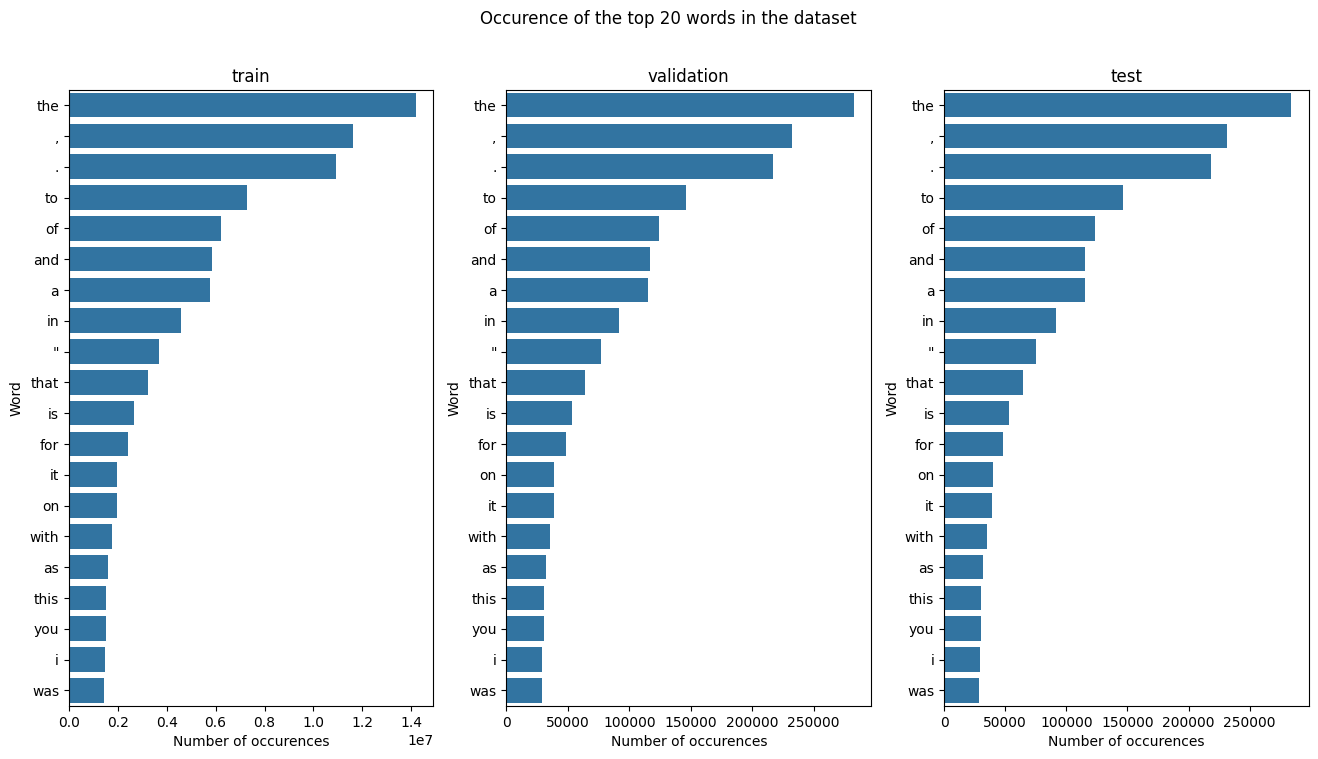

In [10]:
fig = plot_3_plots_side_by_side(dataset_dict, plot_occurence_of_words)
fig.suptitle("Occurence of the top 20 words in the dataset")
plt.show()

As expected, the most common words are stopwords. We will remove them in the next visualization.

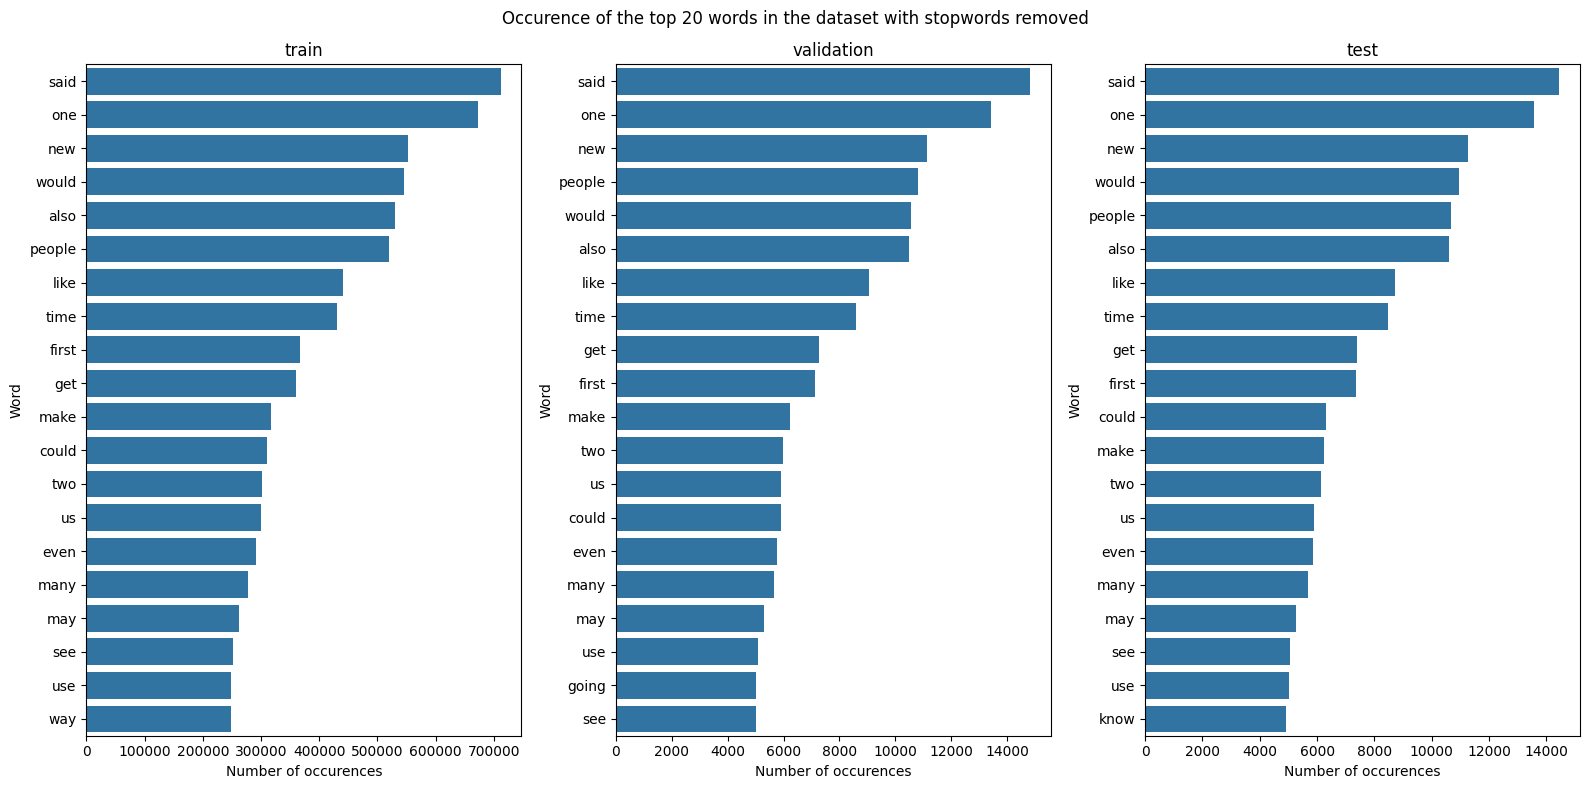

In [11]:
STOPWORDS = set(stopwords.words("english"))


def plot_occurence_of_words_with_stopwords_removed(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the top 20 words in the dataset with stopwords removed.
    :param dataset: Dataset to plot
    :param ax: axis to plot on
    :return: axis with the plot
    """
    tweet_tokenizer = TweetTokenizer(strip_handles=True)
    tokenized_words = [tweet_tokenizer.tokenize(text) for text in dataset["text"]]
    counter = {}
    for text in tokenized_words:
        for word in text:
            if word.lower() not in STOPWORDS and word.isalpha():
                counter[word.lower()] = counter.get(word.lower(), 0) + 1
    word_counts = pd.DataFrame(list(counter.items()), columns=["word", "occurence"])
    word_counts.sort_values(by="occurence", ascending=False, inplace=True)
    sns.barplot(y="word", x="occurence", data=word_counts.iloc[0:20], ax=ax, orient="h")
    ax.set_ylabel("Word")
    ax.set_xlabel("Number of occurences")


fig = plot_3_plots_side_by_side(
    dataset_dict, plot_occurence_of_words_with_stopwords_removed
)
fig.suptitle("Occurence of the top 20 words in the dataset with stopwords removed")
fig.tight_layout()
plt.show()

The most common words are now more meaningful. We can see that the most common words are similar in all datasets.

## Class type occurence

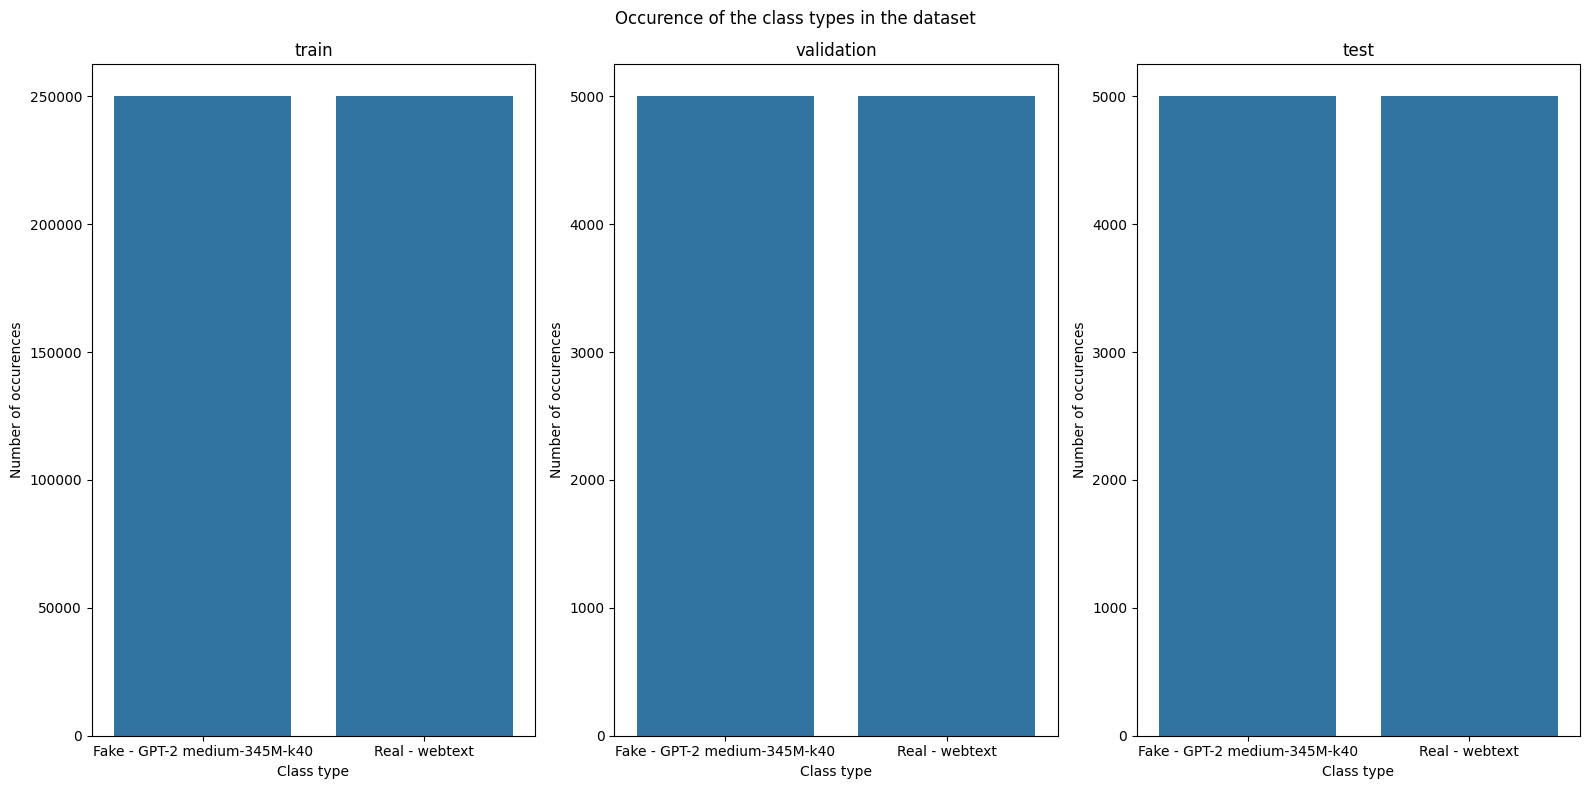

In [14]:
def plot_class_type_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    sns.countplot(x="label", data=dataset.sort_values("label"), ax=ax)
    ax.set_xlabel("Class type")
    ax.set_ylabel("Number of occurences")


fig = plot_3_plots_side_by_side(dataset_dict, plot_class_type_occurence)
fig.suptitle("Occurence of the class types in the dataset")
fig.tight_layout()
plt.show()

It seems that the dataset has similar usage of different types of generating tweets.

## Text length

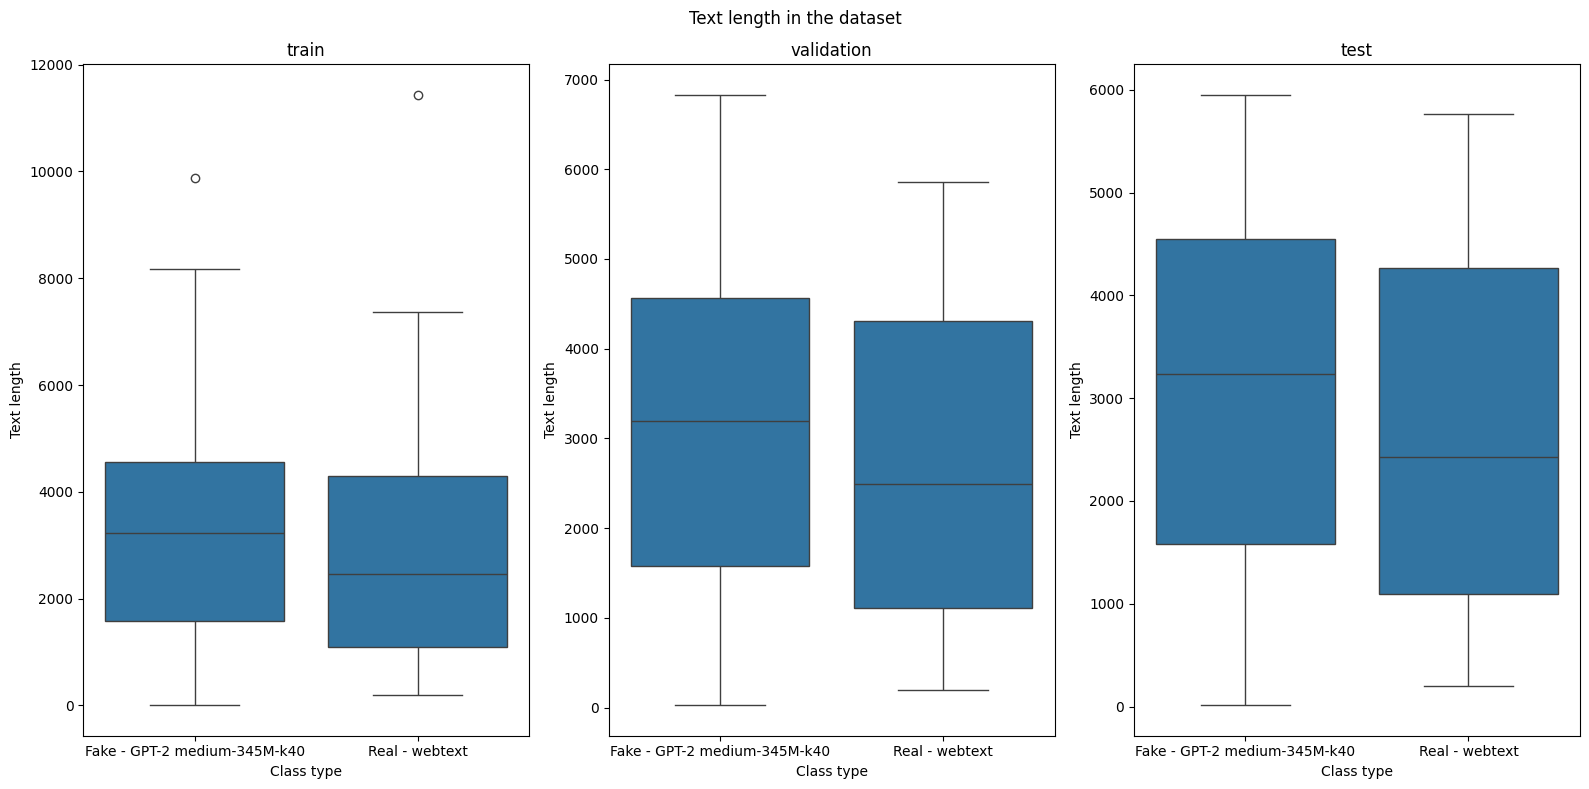

In [16]:
def plot_tweet_length(dataset: pd.DataFrame, ax: plt.Axes):
    mod_df = dataset.copy()
    mod_df["length"] = mod_df["text"].str.len()
    sns.boxplot(mod_df.sort_values(by="label"), x="label", y="length", ax=ax)
    ax.set_xlabel("Class type")
    ax.set_ylabel("Text length")


fig = plot_3_plots_side_by_side(dataset_dict, plot_tweet_length)
fig.suptitle("Text length in the dataset")
fig.tight_layout()
plt.show()